# Библиотеки

In [1]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2
from nltk.stem.snowball import RussianStemmer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader,TensorDataset
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import inspect
from tqdm import tqdm
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import OneCycleLR
import random
from gensim.models import Word2Vec
import ast
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Анализ данных

In [3]:
df = pd.read_csv('train.csv',sep=',',usecols=["text","labels"])
df['label_list']=df['labels'].apply(lambda x: list(map(int,x.split())))
print(df[['text','label_list']].sample(5))#глянем на примеры текстов с метками


                                                    text                                         label_list
6001   26 ноября, воскресенье «Афиша Уфа»\nДетям\n🚩\n...  [1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, ...
26755  🍁\nОсень в ростовском зоопарке\n☀️\nВ осенне-з...  [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, ...
13883  🤟\nTriangle Sun\n🤟\nЗвёзды мировой электронной...  [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, ...
26432  «Мировые рок-хиты с симфоническим оркестром»\n...  [0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, ...
5799   Джаз на крыше с симфоническим оркестром\n8 июл...  [1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, ...


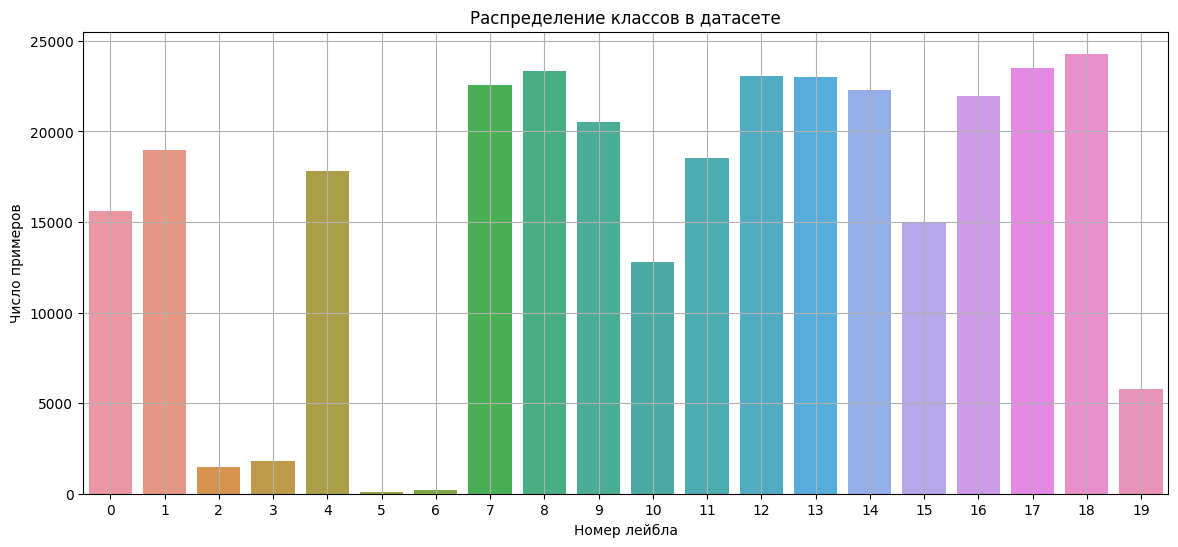

In [4]:
label_matrix=np.array(df['label_list'].tolist())
num_labels=label_matrix.shape[1]
class_counts=label_matrix.sum(axis=0)
plt.figure(figsize=(14,6))
sns.barplot(x=list(range(num_labels)),y=class_counts)
plt.xlabel('Номер лейбла')
plt.ylabel('Число примеров')
plt.title('Распределение классов в датасете')
plt.grid(True)
plt.show()

In [5]:
#глянем на 3 примера для каждого лейбла 
for i in range(num_labels):
    print(f"\n==== Примеры для класса {i} ====")
    examples=df[df['label_list'].apply(lambda x:x[i] == 1)].head(3)['text'].tolist()
    for ex in examples:
        print("—", ex.replace('\n', ' ')[:300], "...\n")


==== Примеры для класса 0 ====
— 15 января Детская развлекательная программа 15-00 бесплатно ❗️ @ cafeotdyh Кафе "Отдых" 📍 Запись обязательно +73472228532 ...

— Впервые в Уфе танцевальная терапия в группе с практикующим психологом Тема встречи: «Отношения. Доверие. Контакт» Приходите, если: 🔸 вы хотите наладить или поисследовать свои отношения с -  телом - собой - близким человеком - работой - деньгами 🔸 не можете разрешить или забыть какую-то  ситуацию, св ...

— 🎹 GRAND PIANO COMPETITION 🎹 Друзья, сегодня открытие IV Международного конкурса GRAND PIANO (для пианистов до 16 лет) в зале Чайковского. Сегодня прозвучит премьера концерта АЛЕКСАНДРА ЧАЙКОВСКОГО для 4 (!!!!) роялей!!! Вместе с ДЕНИСОМ МАЦУЕВЫМ (которому и посвящён этот концерт) будут играть лауреа ...


==== Примеры для класса 1 ====
— Впервые в Уфе танцевальная терапия в группе с практикующим психологом Тема встречи: «Отношения. Доверие. Контакт» Приходите, если: 🔸 вы хотите наладить или поисследовать свои отношения с - 

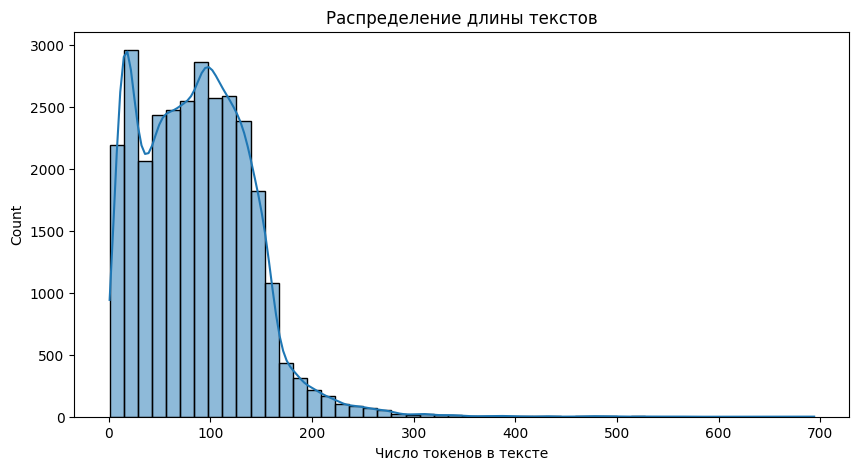

In [6]:
df['text_len']=df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(df['text_len'], bins=50, kde=True)
plt.xlabel('Число токенов в тексте')
plt.title('Распределение длины текстов')
plt.show()

In [7]:
#Итого в  датасете 20 классов, причем чатсть из них дисбалансна (4 класса с очень малым количеством примеров).
#Некоторые классы часто пересекаются (часто отмечаются всемте).
#Длина текстов распределена неравномерно: большинство попадает в диапазон от 30 до 100, есть отдельные выбросы текстов с числом слов около 700
#Это говорит о том, что стоит применять стратифицированный сплит,Ограничивать длину текста (MAX_SEQUENCE_LENGTH)


# Предобработка текста для разных моделей

In [8]:
#чисто технический код
if not hasattr(inspect, 'getargspec'):
    import collections
    def getargspec(func):
        sig = inspect.signature(func)
        args = []
        varargs = None
        varkw = None
        defaults = []
        for param in sig.parameters.values():
            if param.kind == param.VAR_POSITIONAL:
                varargs = param.name
            elif param.kind == param.VAR_KEYWORD:
                varkw = param.name
            else:
                args.append(param.name)
                if param.default is not param.empty:
                    defaults.append(param.default)
        return collections.namedtuple('ArgSpec', 'args varargs keywords defaults')(args, varargs, varkw, tuple(defaults) if defaults else None)
    inspect.getargspec = getargspec


In [9]:
#зададим стоп-слова
tqdm.pandas()
morph = pymorphy2.MorphAnalyzer()
stemmer = RussianStemmer()
stop_words = set(stopwords.words('russian'))

In [10]:
#какая очистка необходима для каждого способа токенизации
#1) TF-IDF - Привести к нижнему регистру, удалить пунктуацию и цифры, стоп-слова, URL, эмоджи, Лемматизация (желательно)
#2)Word2Vec - Привести к нижнему регистру, удалить пунктуацию и цифры, URL, эмоджи не лемматищруем, чтобы не терять формы
#3)Встроенный эмбеддинг + сверточная сеть - Привести к нижнему регистру, удалить пунктуацию и цифры, URL, лемматизировать можно, но необязательно
#4)Встроенный эмбеддинг + рекуррентные сети - Те же самые процедуры, что выше + минимальная нормализация + лемматизация
#5)BERT_like - Не очищаем агрессивно — BERT токенизирует сам (WordPiece), Сохраняем регистр, пунктуацию, эмодзи

In [11]:
#функция для вырезания всего некиррилическоого,повторные пробелы, токенизация, лемматизация и тп
def preprocess_text(text,method='lemmatize'):
    text=text.lower()
    text=re.sub(r'[^а-яё\s]', ' ',text)
    text=re.sub(r'\s+', ' ',text).strip()
    tokens=text.split()
    if method == 'lemmatize':
        tokens=[morph.parse(token)[0].normal_form for token in tokens]
    elif method == 'stem':
        tokens = [stemmer.stem(token) for token in tokens]
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)


In [12]:
def preprocess_tfidf(text):
    return preprocess_text(text, method='lemmatize')  
def preprocess_word2vec(text):
    return preprocess_text(text, method=None)  
def preprocess_cnn(text):
    return preprocess_text(text, method=None)
def preprocess_rnn(text):
    return preprocess_text(text, method='lemmatize')
#для берт моделей минимально обрабатываем
def preprocess_bert(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text  # минимальная очистка

# Функции для обучения

In [13]:
def my_f1_score(y_true,y_pred,eps=1e-7):
    y_true=np.array(y_true)
    y_pred=np.array(y_pred)

    f1_scores=[]
    for i in range(y_true.shape[1]):  
        tp=np.sum((y_true[:, i] == 1) & (y_pred[:, i] == 1))
        fp=np.sum((y_true[:, i] == 0) & (y_pred[:, i] == 1))
        fn=np.sum((y_true[:, i] == 1) & (y_pred[:, i] == 0))

        precision=tp/(tp+fp+eps)
        recall=tp/(tp+fn+eps)
        f1=2*precision*recall/(precision+recall+eps)

        f1_scores.append(f1)

    return np.mean(f1_scores)

In [14]:
def train_epoch(model,dataloader,optimizer,criterion,device):
    model.train()
    total_loss = 0
    all_targets, all_outputs = [], []

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_targets.append(targets.detach().cpu())
        all_outputs.append(torch.sigmoid(logits.detach().cpu()))

    targets = torch.cat(all_targets).numpy()
    outputs = torch.cat(all_outputs).numpy()
    preds = (outputs >= 0.5).astype(int)
    f1 = my_f1_score(targets, preds)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, f1

In [15]:
def eval_epoch(model,dataloader,criterion,device):
    model.eval()
    total_loss = 0
    all_targets, all_outputs = [], []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            loss = criterion(logits, targets)

            total_loss += loss.item()
            all_targets.append(targets.cpu())
            all_outputs.append(torch.sigmoid(logits.cpu()))

    targets = torch.cat(all_targets).numpy()
    outputs = torch.cat(all_outputs).numpy()
    preds = (outputs >= 0.5).astype(int)
    f1 = my_f1_score(targets, preds)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, f1

In [16]:
def plot_metrics(train_losses, val_losses, train_f1s, val_f1s):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_f1s, label='Train F1', marker='o')
    plt.plot(epochs, val_f1s, label='Validation F1', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [17]:
#реализация вормапа
def warmup(optimizer, epoch, warmup_epochs, base_lr):
    if epoch < warmup_epochs:
        lr = base_lr * (epoch + 1) / warmup_epochs
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

# TF-idf + Любая модель

In [18]:
df['processed_text_tf_idf'] = df['text'].progress_apply(lambda x: preprocess_tfidf(x))

100%|██████████| 29568/29568 [07:28<00:00, 65.92it/s]


In [19]:
split_idx=int(0.8 * len(df))
train_df=df.iloc[:split_idx]
val_df=df.iloc[split_idx:]

In [20]:
#загоняем тексты в векторы
vectorizer=TfidfVectorizer(max_features=5000)
X_train=vectorizer.fit_transform(train_df['processed_text_tf_idf']).toarray()
X_val=vectorizer.transform(val_df['processed_text_tf_idf']).toarray()
y_train=np.array(train_df['label_list'].tolist()).astype(np.float32)
y_val=np.array(val_df['label_list'].tolist()).astype(np.float32)
#пропишкм также свой класс
class TfidfDataset(Dataset):
    def __init__(self,X,y):
        self.X=torch.tensor(X,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]

In [21]:
BATCH_SIZE=64
NUM_EPOCHS = 10
WARMUP_EPOCHS = 3
BASE_LR = 1e-3
train_dataset=TfidfDataset(X_train,y_train)
val_dataset=TfidfDataset(X_val,y_val)

train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE)

In [22]:
#запишем самую примитивную модель (FCNN с дропаутами)
class TfidfClassifier(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim,512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512,output_dim)
        )    
    def forward(self,x):
        return self.model(x)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=TfidfClassifier(input_dim=X_train.shape[1], output_dim=y_train.shape[1]).to(device)
criterion=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
steps_per_epoch=len(train_loader)
scheduler=OneCycleLR(optimizer,max_lr=1e-3, 
                       steps_per_epoch=steps_per_epoch,epochs=NUM_EPOCHS)

In [23]:
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

for epoch in range(NUM_EPOCHS):
    warmup(optimizer, epoch, WARMUP_EPOCHS, BASE_LR)
    train_loss, train_f1 = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_f1 = eval_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

Epoch 1/10 | Train Loss: 0.4538 | Train F1: 0.6254 | Val Loss: 0.3435 | Val F1: 0.6820
Epoch 2/10 | Train Loss: 0.2850 | Train F1: 0.7125 | Val Loss: 0.2533 | Val F1: 0.7326
Epoch 3/10 | Train Loss: 0.2254 | Train F1: 0.7665 | Val Loss: 0.2190 | Val F1: 0.7773
Epoch 4/10 | Train Loss: 0.1912 | Train F1: 0.8060 | Val Loss: 0.2066 | Val F1: 0.7952
Epoch 5/10 | Train Loss: 0.1704 | Train F1: 0.8239 | Val Loss: 0.2013 | Val F1: 0.8092
Epoch 6/10 | Train Loss: 0.1552 | Train F1: 0.8423 | Val Loss: 0.1999 | Val F1: 0.8144
Epoch 7/10 | Train Loss: 0.1436 | Train F1: 0.8549 | Val Loss: 0.1996 | Val F1: 0.8267
Epoch 8/10 | Train Loss: 0.1335 | Train F1: 0.8673 | Val Loss: 0.2010 | Val F1: 0.8308
Epoch 9/10 | Train Loss: 0.1249 | Train F1: 0.8779 | Val Loss: 0.2036 | Val F1: 0.8347
Epoch 10/10 | Train Loss: 0.1166 | Train F1: 0.8857 | Val Loss: 0.2057 | Val F1: 0.8356


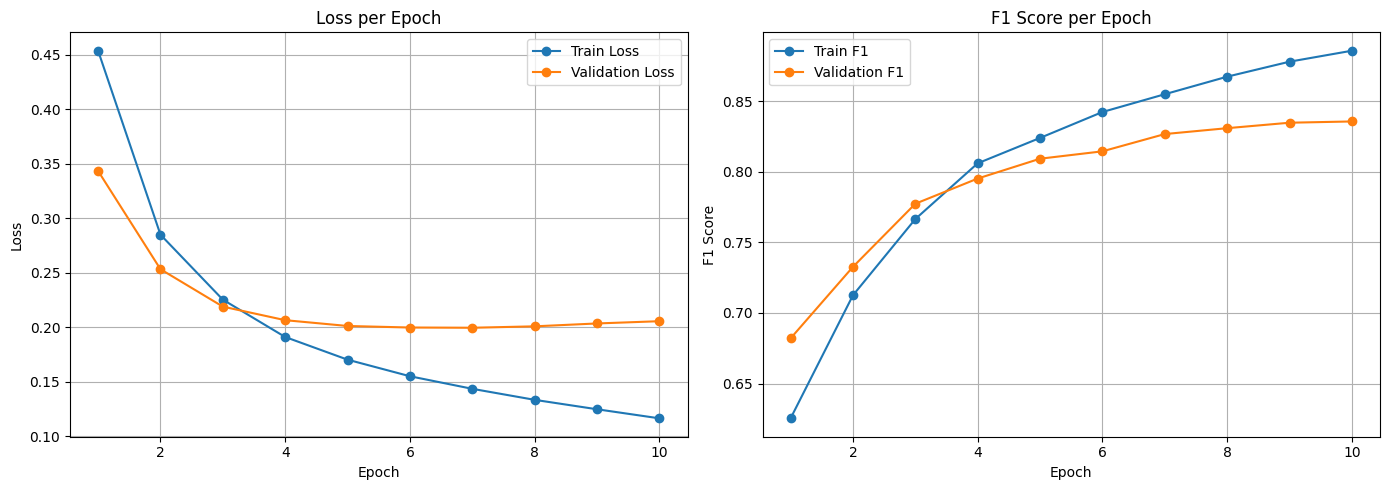

In [24]:
plot_metrics(train_losses, val_losses, train_f1s, val_f1s)

# Word2vec+любая модель

In [25]:
MIN_WORD_FREQUENCY = 1
MAX_SEQUENCE_LENGTH = 1000
EMBED_DIM = 300
NUM_EPOCHS = 30
BATCH_SIZE = 64
BASE_LR = 1e-3
WARMUP_EPOCHS = 3

In [26]:
def encode(text):
    tokens = text.split()
    ids = [vocab.get(token, 0) for token in tokens]
    return ids[:MAX_SEQUENCE_LENGTH] + [0] * max(0, MAX_SEQUENCE_LENGTH - len(tokens))

In [27]:
df['processed_text_word2vec'] = df['text'].progress_apply(lambda x: preprocess_word2vec(x))

100%|██████████| 29568/29568 [00:02<00:00, 13857.05it/s]


In [28]:
#окончательно получим токены и зададим word2vec с окном 5
tokenized_corpus = [text.split() for text in df['processed_text_word2vec']]
counter = Counter(w for doc in tokenized_corpus for w in doc)
vocab = {word: idx + 1 for idx, (word, count) in enumerate(counter.items()) if count >= MIN_WORD_FREQUENCY}
vocab['<PAD>'] = 0


#в датасфере питон 3.10, и с генсимом ничего не конфликтовало
w2v_model=Word2Vec(
    sentences=tokenized_corpus,
    vector_size=EMBED_DIM,
    window=5,
    min_count=MIN_WORD_FREQUENCY,
    sg=1,
    epochs=10,
    workers=4
)

In [29]:
embedding_matrix = np.zeros((len(vocab), EMBED_DIM), dtype=np.float32)
for word, idx in vocab.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(EMBED_DIM,))

labels = df['label_list'].tolist()
texts = df['processed_text_word2vec'].tolist()

In [30]:
encoded_texts = [encode(t) for t in texts]


tensor_texts = torch.tensor(encoded_texts, dtype=torch.long)
tensor_labels = torch.tensor(labels, dtype=torch.float32)


split_idx = int(0.8 * len(tensor_texts))
train_dataset = TensorDataset(tensor_texts[:split_idx], tensor_labels[:split_idx])
val_dataset = TensorDataset(tensor_texts[split_idx:], tensor_labels[split_idx:])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_labels = labels[:split_idx]

In [31]:
#зададим линейную модель с эмбеддингами и пулингаи по среднему
class W2vClassifier(nn.Module):
    def __init__(self,embedding_matrix,num_labels,trainable=False):
        super().__init__()
        num_embeddings, embedding_dim=embedding_matrix.shape
        self.embedding=nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix),freeze=not trainable,padding_idx=0)
        self.fc = nn.Linear(embedding_dim,num_labels)
    def forward(self, x):
        embedded=self.embedding(x) 
        pooled=embedded.mean(dim=1) 
        return self.fc(pooled)

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_labels = len(train_labels[0])
model = W2vClassifier(embedding_matrix, num_labels=num_labels, trainable=True).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=BASE_LR)

train_losses, val_losses = [], []
train_f1s, val_f1s = [], []

for epoch in range(NUM_EPOCHS):
    warmup(optimizer,epoch,WARMUP_EPOCHS,BASE_LR)
    train_loss, train_f1 = train_epoch(model,train_loader,optimizer,criterion,device)
    val_loss, val_f1 = eval_epoch(model,val_loader,criterion,device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")


Epoch 1/30 | Train Loss: 0.5045 | Train F1: 0.5708 | Val Loss: 0.4943 | Val F1: 0.5744
Epoch 2/30 | Train Loss: 0.4834 | Train F1: 0.5804 | Val Loss: 0.4706 | Val F1: 0.5941
Epoch 3/30 | Train Loss: 0.4403 | Train F1: 0.6118 | Val Loss: 0.4094 | Val F1: 0.5978
Epoch 4/30 | Train Loss: 0.3848 | Train F1: 0.6334 | Val Loss: 0.3659 | Val F1: 0.6504
Epoch 5/30 | Train Loss: 0.3539 | Train F1: 0.6720 | Val Loss: 0.3458 | Val F1: 0.6681
Epoch 6/30 | Train Loss: 0.3383 | Train F1: 0.6857 | Val Loss: 0.3341 | Val F1: 0.6979
Epoch 7/30 | Train Loss: 0.3279 | Train F1: 0.6911 | Val Loss: 0.3254 | Val F1: 0.6953
Epoch 8/30 | Train Loss: 0.3194 | Train F1: 0.7021 | Val Loss: 0.3184 | Val F1: 0.7119
Epoch 9/30 | Train Loss: 0.3114 | Train F1: 0.7146 | Val Loss: 0.3116 | Val F1: 0.7111
Epoch 10/30 | Train Loss: 0.3037 | Train F1: 0.7212 | Val Loss: 0.3054 | Val F1: 0.7168
Epoch 11/30 | Train Loss: 0.2961 | Train F1: 0.7263 | Val Loss: 0.2981 | Val F1: 0.7188
Epoch 12/30 | Train Loss: 0.2889 | Train 

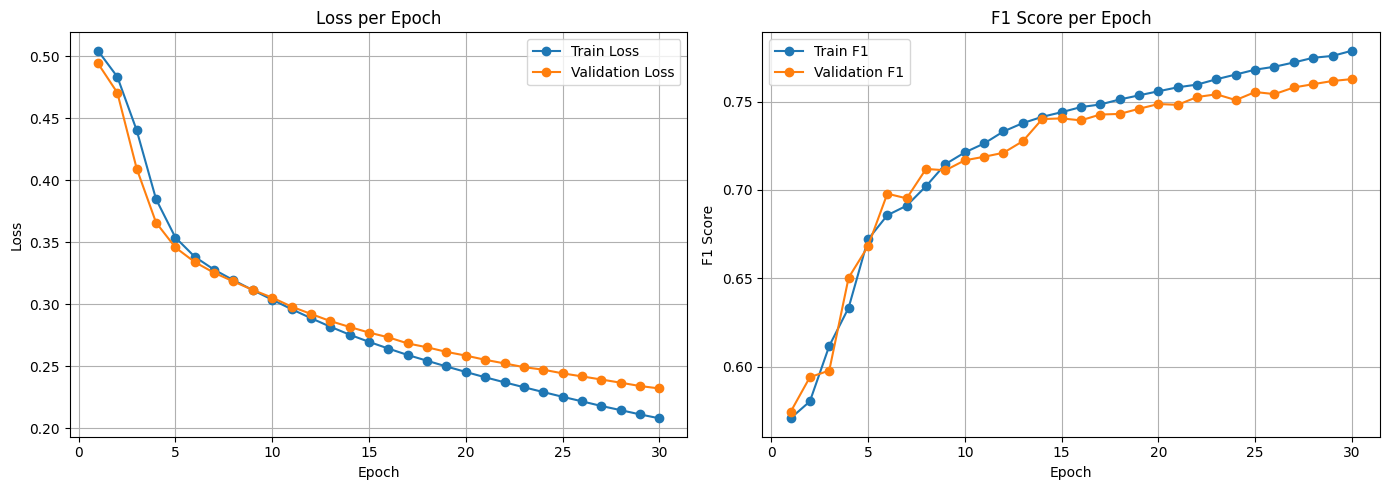

In [33]:
plot_metrics(train_losses, val_losses, train_f1s, val_f1s)

# Встроенный эмбеддинг + сверточные сети

In [34]:
df['processed_cnn'] = df['text'].progress_apply(lambda x: preprocess_cnn(x))

100%|██████████| 29568/29568 [00:02<00:00, 13965.23it/s]


In [35]:
MIN_WORD_FREQUENCY = 1
MAX_SEQUENCE_LENGTH = 1000

train_tokens = df['processed_cnn'].tolist()
counter = Counter(w for doc in train_tokens for w in doc.split())
vocab = {word: idx + 1 for idx, (word, c) in enumerate(counter.items()) if c >= MIN_WORD_FREQUENCY}
vocab['<PAD>'] = 0

encoded_texts = np.array([encode(text) for text in tqdm(df['processed_cnn'])])
labels = np.array(df['label_list'].tolist())

100%|██████████| 29568/29568 [00:00<00:00, 30869.77it/s]


In [36]:

split_idx = int(0.8 * len(df))
train_texts = encoded_texts[:split_idx]
train_labels = labels[:split_idx]
val_texts = encoded_texts[split_idx:]
val_labels = labels[split_idx:]
train_dataset = TensorDataset(torch.tensor(train_texts, dtype=torch.long),torch.tensor(train_labels,dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_texts, dtype=torch.long),torch.tensor(val_labels,dtype=torch.float32))

In [37]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [38]:
#обычная одномерная свертка + допаут
class CNNTextClassifier(nn.Module):
    def __init__(self,vocab_size,embed_dim,num_labels,kernel_sizes=[3,4,5],num_filters=100,dropout=0.5):
        super().__init__()
        self.embedding=nn.Embedding(vocab_size,embed_dim,padding_idx=0)#встроенный эмбеддинг
        self.convs=nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim,out_channels=num_filters,kernel_size=k)
            for k in kernel_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters*len(kernel_sizes),num_labels)
    def forward(self, x):
        embedded=self.embedding(x)
        embedded=embedded.permute(0, 2, 1) 
        conv_outs=[torch.relu(conv(embedded)) for conv in self.convs]
        pooled=[torch.max(c_out, dim=2)[0] for c_out in conv_outs]
        cat=torch.cat(pooled, dim=1)
        dropped=self.dropout(cat)
        logits=self.fc(dropped)
        return logits

In [39]:
EMBED_DIM = 300
NUM_EPOCHS = 30
BASE_LR = 1e-3
WARMUP_EPOCHS = 3
early_stop_threshold = 1e-6
prev_lr = optimizer.param_groups[0]['lr']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNTextClassifier(vocab_size=len(vocab), embed_dim=EMBED_DIM, num_labels=labels.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=BASE_LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

for epoch in range(NUM_EPOCHS):
    warmup(optimizer, epoch, WARMUP_EPOCHS, BASE_LR)
    train_loss, train_f1 = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_f1 = eval_epoch(model, val_loader, criterion, device)
    if epoch >= WARMUP_EPOCHS:
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        if abs(current_lr - prev_lr) < early_stop_threshold:
            print(f"Ранняя остановка {epoch+1} ")
            break
        prev_lr = current_lr


    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

Epoch 1/30 | Train Loss: 0.4237 | Train F1: 0.6307 | Val Loss: 0.3305 | Val F1: 0.6854
Epoch 2/30 | Train Loss: 0.3292 | Train F1: 0.7052 | Val Loss: 0.2747 | Val F1: 0.7371
Epoch 3/30 | Train Loss: 0.2951 | Train F1: 0.7373 | Val Loss: 0.2599 | Val F1: 0.7507
Ранняя остановка 4 


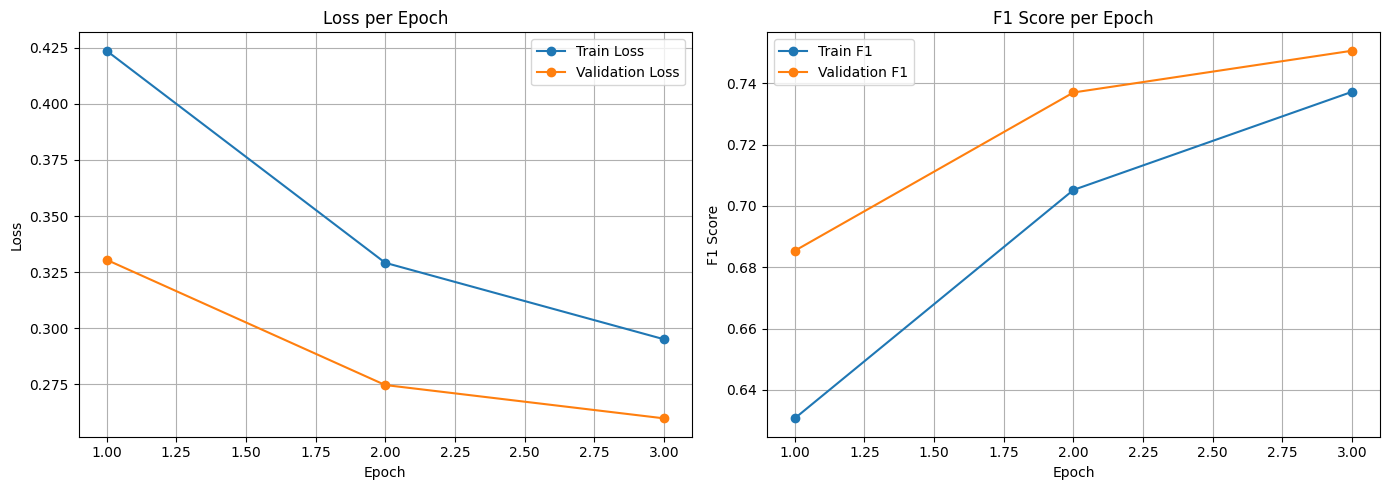

In [40]:
plot_metrics(train_losses, val_losses, train_f1s, val_f1s)

# Встроенный эмбеддинг + рекуррентные сети

In [54]:
#эта модель пошла в итог в каггл

In [55]:
#df['processed_rnn'] = df['text'].progress_apply(lambda x: preprocess_rnn(x))
#будем испоьзовать преобразования тф-идф(они идентичны)

In [56]:
#препроцессинг аналогичен preprocess_tfidf, поэтому возьмем его
df['label_list'] = df['labels'].apply(lambda x: list(map(int, x.split())))
MIN_WORD_FREQUENCY = 1
MAX_SEQUENCE_LENGTH = 1000
SKIPGRAM_N_WORDS = 2
EMBED_DIM = 300
EMBED_MAX_NORM = 1.0
NUM_EPOCHS = 6
BATCH_SIZE = 64
WARMUP_EPOCHS=1
BASE_LR = 1e-3

train_tokens = df['processed_text_tf_idf'].tolist()
counter = Counter(w for doc in train_tokens for w in doc.split())
vocab = {word: idx + 1 for idx, (word, c) in enumerate(counter.items()) if c >= MIN_WORD_FREQUENCY}
vocab['<PAD>'] = 0


In [57]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [encode(t) for t in texts]
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.texts[idx][:MAX_SEQUENCE_LENGTH]
        padded = tokens + [0] * (MAX_SEQUENCE_LENGTH - len(tokens))
        return torch.tensor(padded, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float32)

In [58]:
#здесь также встроенный эмбеддинг + двунапрвленная лстм + обучаются вссеса для вектора контекстов
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_labels):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True, bidirectional=True)
        self.attn = nn.Linear(hidden_size * 2, 1)
        self.bn = nn.BatchNorm1d(hidden_size * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size * 2, num_labels)

    def forward(self, x):
        embedded = self.embedding(x) 
        lstm_out, _ = self.lstm(embedded) 
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)
        context = (lstm_out * attn_weights).sum(dim=1) 
        context = self.dropout(self.bn(context))
        return self.fc(context)

In [59]:
split_idx = int(0.8 * len(df))
train_texts = df['processed_text_tf_idf'][:split_idx].tolist()
train_labels = df['label_list'][:split_idx].tolist()
test_texts = df['processed_text_tf_idf'][split_idx:].tolist()
test_labels = df['label_list'][split_idx:].tolist()

train_dataset = TextDataset(train_texts, train_labels)
test_dataset = TextDataset(test_texts, test_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNClassifier(vocab_size=len(vocab),embed_dim=EMBED_DIM,hidden_size=128,num_labels=len(train_labels[0])).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [61]:
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

for epoch in range(NUM_EPOCHS):
    warmup(optimizer, epoch, WARMUP_EPOCHS, BASE_LR)
    train_loss, train_f1 = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_f1 = eval_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

Epoch 1/6 | Train Loss: 0.3317 | Train F1: 0.7098 | Val Loss: 0.3467 | Val F1: 0.7569
Epoch 2/6 | Train Loss: 0.2129 | Train F1: 0.8042 | Val Loss: 0.4231 | Val F1: 0.7567
Epoch 3/6 | Train Loss: 0.1795 | Train F1: 0.8567 | Val Loss: 0.6848 | Val F1: 0.6772
Epoch 4/6 | Train Loss: 0.1519 | Train F1: 0.8841 | Val Loss: 0.3431 | Val F1: 0.8270
Epoch 5/6 | Train Loss: 0.1304 | Train F1: 0.8998 | Val Loss: 0.2089 | Val F1: 0.8480
Epoch 6/6 | Train Loss: 0.1099 | Train F1: 0.9127 | Val Loss: 0.2165 | Val F1: 0.8573


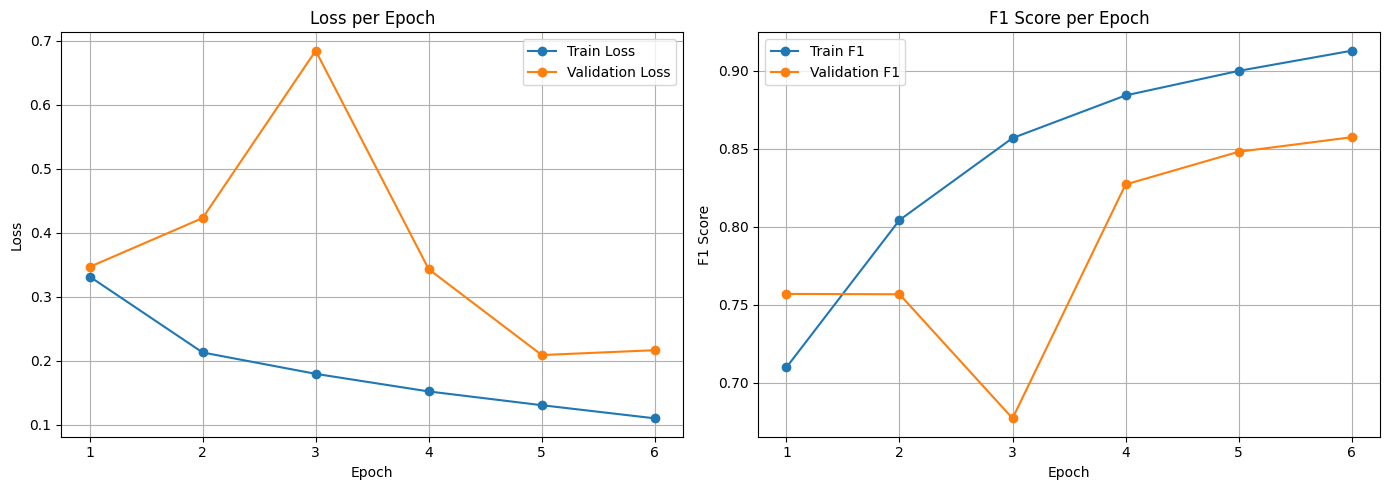

In [62]:
plot_metrics(train_losses, val_losses, train_f1s, val_f1s)

In [63]:
#сделаем сабмишн модели

# Предикт и самбмишн

In [64]:
test_df=pd.read_csv('test.csv')

In [65]:
test_df['processed_text'] = test_df['text'].progress_apply(lambda x: preprocess_tfidf(x))

100%|██████████| 7392/7392 [01:54<00:00, 64.64it/s]


In [66]:
test_tokens = test_df['processed_text'].tolist()
def encode_test(text):
    return [vocab.get(word, 0) for word in text.split()]
test_texts = [encode_test(t) for t in test_tokens]

In [67]:
def pad_sequence(tokens, max_len=MAX_SEQUENCE_LENGTH):
    return tokens[:max_len] + [0] * (max_len - len(tokens))

test_texts_padded = [pad_sequence(t) for t in test_texts]
test_tensor = torch.tensor(test_texts_padded, dtype=torch.long).to(device)

model.eval() 
predictions = []
with torch.no_grad():
    for i in tqdm(range(0, len(test_tensor), BATCH_SIZE)):
        batch = test_tensor[i:i+BATCH_SIZE]
        outputs = model(batch)
        probas = torch.sigmoid(outputs).cpu().numpy()
        predictions.extend(probas)

threshold = 0.5
pred_labels = (np.array(predictions) >= threshold).astype(int)
ids = list(range(29568, 36960))

label_strings = [' '.join(map(str, row)) for row in pred_labels]
result_df = pd.DataFrame({
    'id': ids,
    'labels': label_strings
})

#result_df.to_csv("submission_888.csv", index=False)

100%|██████████| 116/116 [00:01<00:00, 78.77it/s]


# Embedder + Bert

In [68]:
df['processed_bert'] = df['text'].progress_apply(lambda x: preprocess_bert(x))

100%|██████████| 29568/29568 [00:01<00:00, 22846.48it/s]


In [69]:
#Инициализация и тренировка токенизатора в памяти
texts=df['processed_bert'].tolist()
tokenizer=BertWordPieceTokenizer(
    clean_text=True,handle_chinese_chars=False,
    strip_accents=False,lowercase=True)
tokenizer.train_from_iterator(texts, vocab_size=30000)

In [70]:
vocab=tokenizer.get_vocab()
token2id=tokenizer.get_vocab()
id2token={v: k for k, v in token2id.items()}
MAX_LEN=128

def encode_bert(text):
    tokens = tokenizer.encode(text)
    ids = tokens.ids[:MAX_LEN]
    if len(ids) < MAX_LEN:
        ids += [0] * (MAX_LEN - len(ids))  # паддинг
    return ids
df['input_ids'] = df['processed_bert'].apply(encode_bert)

In [71]:
df['label_bert'] = df['labels'].apply(lambda x:list(map(int, x.strip().split())))
X = torch.tensor(df['input_ids'].tolist(), dtype=torch.long)
y = torch.tensor(np.stack(df['label_bert'].values), dtype=torch.float32)

n = len(X)
split_idx = int(n * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [72]:
class BertClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_labels, max_len=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_embedding = nn.Embedding(max_len, embed_dim)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4), num_layers=2
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(embed_dim, num_labels)

    def forward(self, x):
        pos = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        emb = self.embedding(x) + self.pos_embedding(pos)
        emb = emb.permute(1, 0, 2)  # seq_len, batch, embed
        enc = self.encoder(emb)
        pooled = enc.mean(dim=0)  # average pooling
        return self.fc(self.dropout(pooled))

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert = BertClassifier(
    vocab_size=len(token2id),embed_dim=128,num_labels=y.shape[1]).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_bert.parameters(), lr=1e-3)

In [74]:
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []
NUM_EPOCHS=15
for epoch in range(NUM_EPOCHS):
    train_loss, train_f1 = train_epoch(model_bert, train_loader, optimizer, criterion, device)
    val_loss, val_f1 = eval_epoch(model_bert, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

Epoch 1/15 | Train Loss: 0.3372 | Train F1: 0.6875 | Val Loss: 0.2901 | Val F1: 0.7276
Epoch 2/15 | Train Loss: 0.2767 | Train F1: 0.7246 | Val Loss: 0.2660 | Val F1: 0.7389
Epoch 3/15 | Train Loss: 0.2554 | Train F1: 0.7376 | Val Loss: 0.2553 | Val F1: 0.7408
Epoch 4/15 | Train Loss: 0.2375 | Train F1: 0.7462 | Val Loss: 0.2507 | Val F1: 0.7384
Epoch 5/15 | Train Loss: 0.2235 | Train F1: 0.7556 | Val Loss: 0.2425 | Val F1: 0.7472
Epoch 6/15 | Train Loss: 0.2100 | Train F1: 0.7645 | Val Loss: 0.2411 | Val F1: 0.7550
Epoch 7/15 | Train Loss: 0.1980 | Train F1: 0.7725 | Val Loss: 0.2378 | Val F1: 0.7534
Epoch 8/15 | Train Loss: 0.1860 | Train F1: 0.7792 | Val Loss: 0.2378 | Val F1: 0.7627
Epoch 9/15 | Train Loss: 0.1746 | Train F1: 0.7849 | Val Loss: 0.2453 | Val F1: 0.7634
Epoch 10/15 | Train Loss: 0.1642 | Train F1: 0.7932 | Val Loss: 0.2447 | Val F1: 0.7636
Epoch 11/15 | Train Loss: 0.1534 | Train F1: 0.7997 | Val Loss: 0.2456 | Val F1: 0.7726
Epoch 12/15 | Train Loss: 0.1434 | Train 

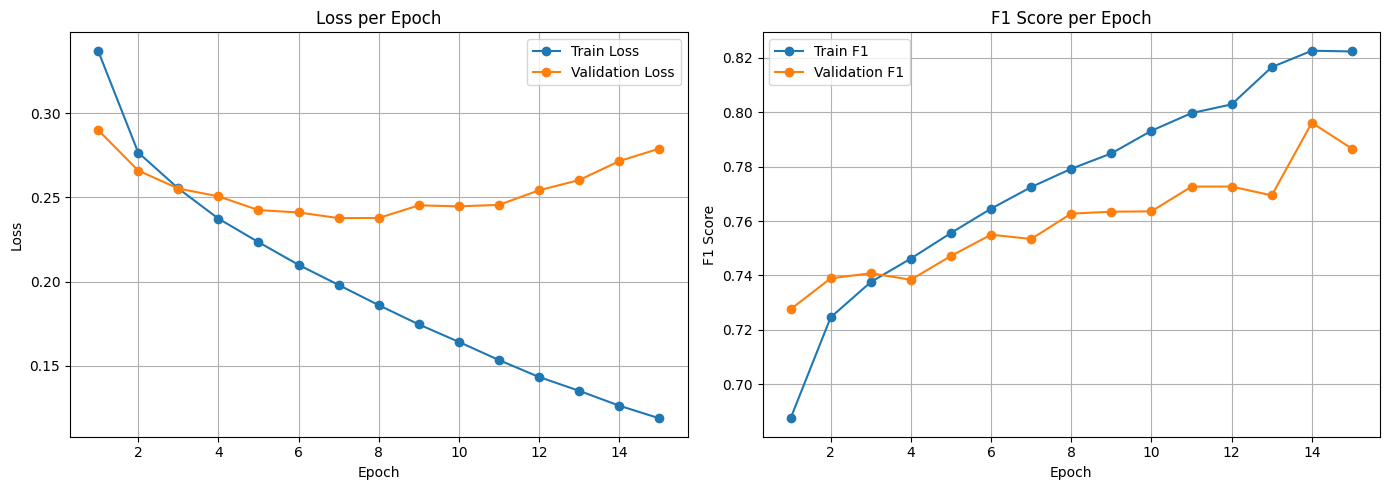

In [75]:
plot_metrics(train_losses, val_losses, train_f1s, val_f1s)

# Декодер

In [76]:
MAX_SEQUENCE_LENGTH=1000
EPOCHS=10

texts = [preprocess_bert(t) for t in df['text'].tolist()]
tokenizer = BertWordPieceTokenizer(lowercase=True)
tokenizer.train_from_iterator(texts, vocab_size=3000)
tokenizer.enable_padding(length=64)
tokenizer.enable_truncation(max_length=64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df['label_dec'] = df['labels'].apply(lambda x: list(map(int, x.strip().split())))

In [77]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.tokenizer = tokenizer
        self.labels = labels
        self.encodings = [tokenizer.encode(t) for t in texts]
    def __len__(self):
        return len(self.encodings)
    def __getitem__(self, idx):
        encoding = self.encodings[idx]
        ids = encoding.ids
        return torch.tensor(ids, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float32)

In [78]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, df['label_dec'].tolist(), test_size=0.2, random_state=42)

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [79]:
class MyDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        logits = self.fc(out)
        return logits, hidden

In [80]:
def train_decoder(model, dataloader, optimizer, criterion, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        batch_count = 0
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            targets = inputs.clone().to(device)  # авто-реконструкция
            optimizer.zero_grad()
            logits, _ = model(inputs)
            loss = criterion(logits.view(-1, logits.size(-1)), targets.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batch_count += 1
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / batch_count:.4f}")

In [81]:
def generate_text(model, tokenizer, max_len=64, seed_id=None):
    model.eval()
    if seed_id is None:
        seed_id = random.randint(100, tokenizer.get_vocab_size() - 1)

    input_ids = torch.tensor([[seed_id]], dtype=torch.long).to(device)
    generated = [seed_id]

    hidden = None
    for _ in range(max_len - 1):
        logits, hidden = model(input_ids, hidden)
        next_token_logits = logits[:, -1, :]
        next_token = torch.argmax(next_token_logits, dim=-1)
        generated.append(next_token.item())
        input_ids = next_token.unsqueeze(0)

    return tokenizer.decode(generated, skip_special_tokens=True)

In [82]:
vocab_size = tokenizer.get_vocab_size()
model_decode = MyDecoder(vocab_size=vocab_size, embed_dim=128, hidden_dim=256).to(device)
optimizer = torch.optim.Adam(model_decode.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=0)
train_decoder(model_decode, train_loader, optimizer, criterion, device, epochs=5)

Epoch 1/5 - Loss: 0.8601
Epoch 2/5 - Loss: 0.0132
Epoch 3/5 - Loss: 0.0043
Epoch 4/5 - Loss: 0.0018
Epoch 5/5 - Loss: 0.0008


In [83]:
generated_texts = [generate_text(model_decode, tokenizer) for _ in range(1000)]

from sklearn.utils import resample
labels_sampled = resample(train_labels, n_samples=1000, random_state=42)

df_augmented = df.copy()
df_gen = pd.DataFrame({
    'text': generated_texts,
    'labels': labels_sampled
})
df_augmented = pd.concat([df_augmented, df_gen], ignore_index=True)

In [84]:
df_augmented.shape

(30568, 11)

In [85]:
df_augmented['processed_rnn'] = df_augmented['text'].progress_apply(lambda x: preprocess_rnn(x))

100%|██████████| 30568/30568 [07:34<00:00, 67.23it/s] 


In [86]:
MIN_WORD_FREQUENCY = 1
MAX_SEQUENCE_LENGTH = 1000
SKIPGRAM_N_WORDS = 2
EMBED_DIM = 300
EMBED_MAX_NORM = 1.0
NUM_EPOCHS = 5
BATCH_SIZE = 64
WARMUP_EPOCHS=3
BASE_LR = 1e-3

train_tokens = df_augmented['processed_rnn'].tolist()
counter = Counter(w for doc in train_tokens for w in doc.split())
vocab = {word: idx + 1 for idx, (word, c) in enumerate(counter.items()) if c >= MIN_WORD_FREQUENCY}
vocab['<PAD>'] = 0


In [87]:
df_augmented['label_list'] = df_augmented['labels'].apply(
    lambda x: list(map(int, x.strip().split())) if isinstance(x, str) else x
)

In [88]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_augmented['text'].tolist(),
    df_augmented['label_list'].tolist(),
    test_size=0.2,
    random_state=42
)
train_dataset_aug = TextDataset(train_texts, train_labels, tokenizer)
val_dataset_aug = TextDataset(val_texts, val_labels, tokenizer)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=32)

In [90]:
vocab_size = tokenizer.get_vocab_size()
num_labels = len(train_labels[0])

model_2 = RNNClassifier(vocab_size, embed_dim=128, hidden_size=128, num_labels=num_labels).to(device)
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

NUM_EPOCHS = 10
train_losses, val_losses, train_f1s, val_f1s = [], [], [], []

for epoch in range(NUM_EPOCHS):
    train_loss, train_f1 = train_epoch(model_2, train_loader_aug, optimizer, criterion, device)
    val_loss, val_f1 = eval_epoch(model_2, val_loader_aug, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

Epoch 1/10 | Train Loss: 0.4017 | Train F1: 0.6803 | Val Loss: 0.3350 | Val F1: 0.7048
Epoch 2/10 | Train Loss: 0.3153 | Train F1: 0.7229 | Val Loss: 0.3132 | Val F1: 0.7331
Epoch 3/10 | Train Loss: 0.2884 | Train F1: 0.7449 | Val Loss: 0.2969 | Val F1: 0.7443
Epoch 4/10 | Train Loss: 0.2691 | Train F1: 0.7649 | Val Loss: 0.2952 | Val F1: 0.7501
Epoch 5/10 | Train Loss: 0.2518 | Train F1: 0.7780 | Val Loss: 0.2916 | Val F1: 0.7563
Epoch 6/10 | Train Loss: 0.2359 | Train F1: 0.7900 | Val Loss: 0.2935 | Val F1: 0.7535
Epoch 7/10 | Train Loss: 0.2194 | Train F1: 0.8012 | Val Loss: 0.2932 | Val F1: 0.7610
Epoch 8/10 | Train Loss: 0.2050 | Train F1: 0.8127 | Val Loss: 0.2936 | Val F1: 0.7646
Epoch 9/10 | Train Loss: 0.1950 | Train F1: 0.8229 | Val Loss: 0.3027 | Val F1: 0.7663
Epoch 10/10 | Train Loss: 0.1838 | Train F1: 0.8275 | Val Loss: 0.3089 | Val F1: 0.7698
